In [1]:
!pip install -r requirements.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

import os
import requests
import threading
import urllib

# Get Data From API

## Generic Info
- How many breeds?
- How many images for each breed?

Save the information to a local file (`breeds.txt`) so that no need to request API next time

In [3]:
def process_breeds():
    req = requests.get("https://dog.ceo/api/breeds/list/all")
    breeds_set = req.json()['message']
    breed_names = list(breeds_set.keys())

    print("Num of different (main) breeds:", len(breed_names))

    breeds = []
    for i in range(len(breed_names)):
        breed = breed_names[i]
        req_str = "https://dog.ceo/api/breed/{0}/images".format(breed)
        req = requests.get(req_str)

        breeds.append((breed, len(req.json()['message'])))

    for i in range(5):
        print(breeds[i])

    # Save to file
    f = open("breeds.txt", "w")
    f.write("breed,count\n")

    for i in range(len(breeds)):
        line = "{0},{1}\n".format(breeds[i][0], breeds[i][1])
        f.write(line)

    f.close()

In [4]:
process_breeds()

Num of different (main) breeds: 95
('affenpinscher', 150)
('african', 169)
('airedale', 202)
('akita', 9)
('appenzeller', 151)


## Download Image Data
There are 18k images for 95 breeds in total from the API.

Since no limit on number of concurrent requests from the server, use multithreading for downloading the images. It should take a total of less than 5 mins.

### Organisation of images downloaded:
The data are downloaded to `./dog/[breed_name]/[breed_name]_xxx.jpg` where `[breed_name]` is the dog's breed and `xxx` is a 3-digit int from 000 to 999

In [5]:
def download_imgs(breeds):
    img_count = 0

    if not os.path.exists('dog'):
        os.makedirs('dog')

    start_down = False

    for breed in breeds:
        if breed == "retriever":
            start_down = True

        if not start_down:
            continue

        path_str = 'dog/' + breed
        if not os.path.exists(path_str):
            os.makedirs(path_str)

        print("Start for breed", breed)
        req_str = "https://dog.ceo/api/breed/{0}/images".format(breed)
        resp = requests.get(req_str).json()

        img_sources = resp['message']
        for i in range(len(img_sources)):

            source = img_sources[i]
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)

            #urllib.request.urlretrieve(source, img_path)
            create_thread_for_download(source, img_path)

            img_count += 1

        print("Download all images for breed {0}.".format(breed))

    print("Success downloading all {0} images.".format(img_count))


# Use multithreading for download images
def download_by_req(source, img_path):
    urllib.request.urlretrieve(source, img_path)


def create_thread_for_download(source, img_path):
    download_thread = threading.Thread(target=download_by_req, args=(source, img_path))
    download_thread.start()

In [6]:
# download_imgs(breed_names)

In [4]:
breed_names_used = {'bulldog', 'hound', 'mountain', 'poodle', 'retriever', 'schnauzer', 'setter', 'sheepdog', 'spaniel', 'terrier'}
breed_names_dict = {}
label = 1
for breed in breed_names_used:
    breed_names_dict[breed] = label
    label += 1
print(breed_names_dict)

{'terrier': 1, 'bulldog': 2, 'schnauzer': 3, 'sheepdog': 4, 'retriever': 5, 'spaniel': 6, 'mountain': 7, 'setter': 8, 'hound': 9, 'poodle': 10}


# Resize all images
All images will be center-cropped and resized to dimension 224 x 224 (dimensions can be changed later)

In [2]:
# resize all images in all folders to be of the same dimension
def resize_all_imgs(breed_names_dict):
    for breed in breed_names_dict:
        path_str = 'dog/' + breed
        path_new_str = 'new_dog/' + breed
        if not os.path.exists(path_new_str):
            os.makedirs(path_new_str)

        num_files = len([f for f in os.listdir(path_str) if os.path.isfile(os.path.join(path_str, f))])
        for i in tqdm(range(num_files)):
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)
            img_path_new = "{0}/{1}_{2:03}.jpg".format(path_new_str, breed, i)

            img = Image.open(img_path)
            size = min(img.size)
            hmargin = (img.size[0] - size) // 2
            vmargin = (img.size[1] - size) // 2
            img = img.crop((hmargin, vmargin, size+hmargin, size+vmargin))
            img = img.resize((224, 224))
            img = img.convert('RGB')
            img.save(img_path_new)

In [5]:
resize_all_imgs(breed_names_dict)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 471/471 [00:03<00:00, 156.48it/s]


# Generate csv containing image_name, label pairs

In [6]:
def generate_csv(breed_names_dict):
    csv_file = open("dog_data.csv", "w")
    csv_file.write("image_name,label\n")

    for breed in breed_names_dict:
        path_str = 'new_dog/' + breed
        
        num_files = len([f for f in os.listdir(path_str) if os.path.isfile(os.path.join(path_str, f))])
        for i in range(0, num_files):
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)
            csv_file.write("{0},{1}\n".format(img_path, breed_names_dict[breed]))

    csv_file.close()

In [7]:
generate_csv(breed_names_dict)

# Understand data

## TODO:
- [ ] Choose the appropriate number of labels
- [ ] Understand the different sizes of images

In [12]:
dogs = pd.read_csv("breeds.txt", sep=",")

In [13]:
# descriptive statistics:
print("Total breed numbers:", len(dogs))
print("Total image numbers:", dogs["count"].sum())

Total breed numbers: 95
Total image numbers: 18225


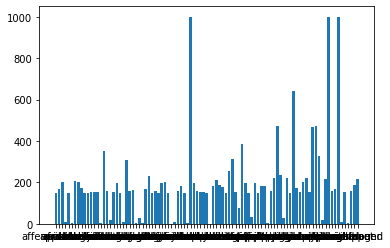

In [14]:
plt.bar(dogs["breed"], height=dogs["count"])
plt.show()

In [15]:
dogs = dogs.sort_values("count", ascending=0)

In [16]:
dogs.head(20)

,breed,count
88,terrier,1000
85,spaniel,1000
42,hound,1000
74,retriever,639
81,setter,471
69,poodle,471
80,schnauzer,466
58,mountain,387
15,bulldog,350
82,sheepdog,328


Consider the first k labels(breeds) with most number of images:


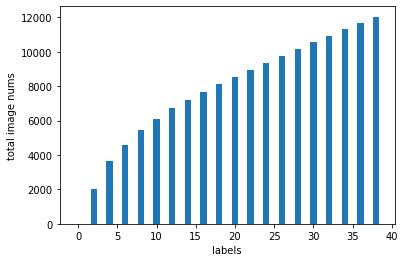

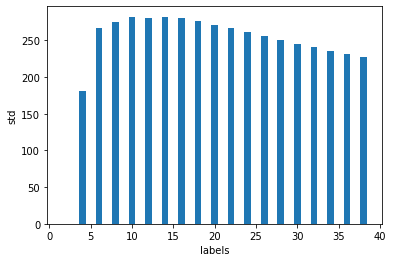

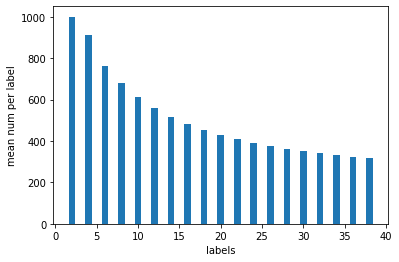

In [17]:
first_x = [*range(0,40,2)]

cummu_sum = [dogs["count"][:x].sum() for x in first_x]
cummu_sd = [dogs["count"][:x].std() for x in first_x]
cummu_mean = [dogs["count"][:x].mean() for x in first_x]

print("Consider the first k labels(breeds) with most number of images:")

fig, ax = plt.subplots()
ax.set_ylabel('total image nums')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_sum)


fig, ax = plt.subplots()
ax.set_ylabel('std')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_sd)

fig, ax = plt.subplots()
ax.set_ylabel('mean num per label')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_mean)


plt.show()

# Perform image augmentation to downloaded images

Augmentations include rotations, shifting, flipping and adding noise

In [16]:
from skimage import transform
from skimage.filters import gaussian
from skimage.io import imread, imshow, imsave
from skimage.transform import rotate
from skimage.util import img_as_ubyte, random_noise

In [3]:
data = pd.read_csv("dog_data.csv")
data.head()
all_img = []
for image_path in tqdm(data['image_name']):
    img = imread(image_path)
    all_img.append(np.array(img, dtype=np.uint8))

train_x = np.stack(all_img)
train_y = data['label'].values
train_x.shape, train_y.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6112/6112 [00:07<00:00, 811.92it/s]


((6112, 224, 224, 3), (6112,))

In [15]:
label, counts = np.unique(train_y, return_counts=True)
y_count = dict(zip(label, counts))
y_count

{1: 1000,
 2: 350,
 3: 466,
 4: 328,
 5: 639,
 6: 1000,
 7: 387,
 8: 471,
 9: 1000,
 10: 471}

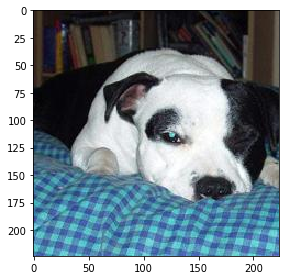

In [4]:
imshow(train_x[np.random.choice(train_x.shape[0])])

In [7]:
all_img = []
train_aug_x = []
train_aug_y = []

for i in tqdm(range(train_x.shape[0])):
    img, label = train_x[i], train_y[i]
    all_img.extend([
        img,
        img_as_ubyte(rotate(img, angle=45, mode='wrap')),
        np.fliplr(img),
        np.flipud(img),
        img_as_ubyte(random_noise(train_x[i],var=0.2**2))
    ])
    train_aug_y.extend([train_y[i]] * 5)

train_aug_x = np.stack(all_img)
train_aug_y = np.array(train_aug_y)
train_aug_x.shape, train_aug_y.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6112/6112 [00:43<00:00, 141.59it/s]


((30560, 224, 224, 3), (30560,))

In [20]:
# Ref:
# https://towardsdatascience.com/image-augmentation-with-skimage-python-7f53f1b0eeb5
def get_aug_img(img, multiplier):
    res = [
        img,
        np.fliplr(img),
        img_as_ubyte(rotate(img, angle=45, mode='wrap')),
        img_as_ubyte(random_noise(img, var=0.2**2)),
        np.flipud(img),
        img_as_ubyte(rotate(img, angle=30, mode='wrap')),
        transform.rescale(img, 1.1)
    ]
    
    return res[:multiplier]
    

In [22]:
# balanced augmentation
balanced_img = []
balanced_x = []
balanced_y = []

for i in tqdm(range(train_x.shape[0])):
    img, label = train_x[i], train_y[i]
    
    # multiplier round to nearest, such as each class around 2000 instances
    aug_multiplier = int(2000 / y_count[label] + 0.5) 
    balanced_img.extend(get_aug_img(img=img, multiplier=aug_multiplier))
    balanced_y.extend([label] * aug_multiplier)

# to image data
balanced_x = np.stack(balanced_img)
balanced_y = np.array(balanced_y)
balanced_x.shape, balanced_y.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6112/6112 [02:04<00:00, 49.11it/s]


((19552, 224, 224, 3), (19552,))

In [23]:
# Show the augmented number for each label
label, counts = np.unique(balanced_y, return_counts=True)
y_count_balanced = dict(zip(label, counts))
y_count_balanced

{1: 2000,
 2: 2100,
 3: 1864,
 4: 1968,
 5: 1917,
 6: 2000,
 7: 1935,
 8: 1884,
 9: 2000,
 10: 1884}

see results of augmentation

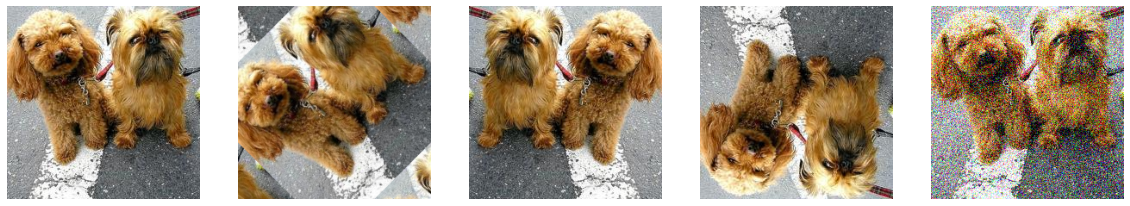

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20, 20))
idx = np.random.choice(train_x.shape[0])
for i in range(5):
    ax[i].imshow(train_aug_x[idx*5 + i])
    ax[i].axis('off')

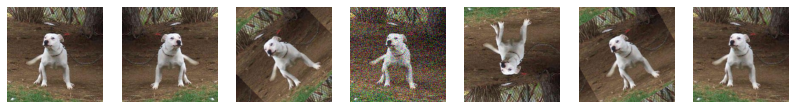

In [21]:
# Test all 7 types of augmentations
fig, ax = plt.subplots(nrows = 1, ncols = 7, figsize = (14, 14))

idx = np.random.choice(train_x.shape[0])

augs = get_aug_img(img=train_x[100], multiplier=7)

for i in range(7):
    ax[i].imshow(augs[i])
    ax[i].axis('off')

# Save Data to File


The 0-indexed 10 labels are:
- 0: terrier
- 1: bulldog
- 2: schnauzer
- 3: sheepdog
- 4: retriever
- 5: spaniel
- 6: mountain
- 7: setter
- 8: hound
- 9: poodle



In [24]:
import torch
import torch.nn as nn

/Users/yiyang/miniconda3/envs/cv_proj/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### For Balanced ~~Unaugmented~~ Data
- ~~6k data points~~
- ~~Store images of both size `224*224` and `32*32`~~

- A total of 19k images
- In both 32*32 and 224*224 Dimension
- All x tensors are saved as **ByteTensor** (0~255) to save space

In [27]:
# NOT: Save unaugmented data
# INSTEAD: Save balanced data

train_x = torch.tensor(balanced_x)
train_x = train_x.permute(0, 3, 1, 2).contiguous()  # from NHWC to NCHW, but permute() breaks contiguous 

In [28]:
train_y = torch.tensor(balanced_y)
train_y = train_y - 1

In [29]:
train_x_32 = nn.functional.interpolate(train_x, size=(32,32))

In [33]:
# A quick check
print(train_x.is_contiguous())
print(train_x.type())
print(train_y.type())
print(train_x_32.is_contiguous())
print(train_x_32.type())

True
torch.ByteTensor
torch.LongTensor
True
torch.ByteTensor


In [34]:
# Save to file
torch.save(train_x_32, 'balan_data_small.pt')
torch.save(train_x   , 'balan_data_large.pt')
torch.save(train_y   , 'balan_label.pt')

### For Augmented Data
- 30k data
- Store only images of size `224*224`

In [27]:
train_aug_x = torch.tensor(train_aug_x).float()
train_aug_x = train_aug_x.permute(0, 3, 1, 2).contiguous() # from NHWC to NCHW, but permute() breaks contiguous 

In [32]:
train_aug_y = torch.tensor(train_aug_y)
train_aug_y = train_aug_y - 1 # convert to 0-indexed

/var/folders/q_/gx93z5_j6sq4x5mqt6jxpw800000gn/T/ipykernel_7949/784503934.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_aug_y = torch.tensor(train_aug_y)


In [29]:
# A quick check
print(train_aug_x.is_contiguous())
print(train_aug_x.type())
print(train_aug_y.type())

True
torch.FloatTensor
torch.LongTensor


In [33]:
# save data
torch.save(train_aug_y,'aug_label.pt')

In [31]:
torch.save(train_aug_x,'aug_data.pt')